<a href="https://www.kaggle.com/code/rajatharigasp/mnist-cnn-using-imagedatagenerator?scriptVersionId=103202476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

**Importing data and creating required arrays**

In [2]:
train_path = pd.read_csv("../input/digit-recognizer/train.csv")
test_path = pd.read_csv("../input/digit-recognizer/test.csv")

print (train_path.shape)
print (test_path.shape)

(42000, 785)
(28000, 784)


In [3]:
train_data = np.array(train_path.iloc[:,1:])
train_x = []
train_y = train_path.iloc[:,0:1]

test_data = np.array(test_path)
test_x = []

#Reshaping the training data
for i in range(42000):
    train_x.append(train_data[i].reshape(28,28,1))

#Reshaping the test data
for i in range(28000):
    test_x.append(test_data[i].reshape(28,28,1))

#Converting list to array
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)/255


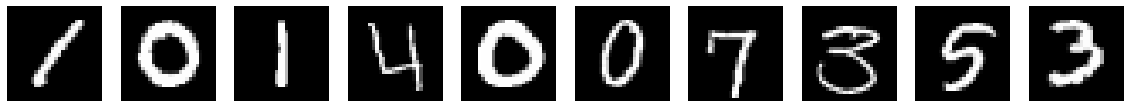

In [4]:
#Visulaising the training data

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('Off')
    plt.imshow(train_x[i],cmap='gray')

**Modifying data using keras ImageDataGenerator**

In [5]:
#Data Augmentation
Batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./ 255, 
                             rotation_range = 30,  
                             height_shift_range = 0.3,
                             validation_split=0.3  #30% of the training data will be used for validation
                            )

                            
train_datagen.fit(train_x)




augmented_training_data = train_datagen.flow(train_x,train_y, 
                                             batch_size = Batch_size, 
                                             subset = "training",
                                             seed = 2021,
                                             shuffle = True)

validation_data = train_datagen.flow(train_x,train_y, 
                                     batch_size = Batch_size,
                                     subset = "validation",
                                     seed = 2021,
                                     shuffle = True)

visual_data = train_datagen.flow(train_x)


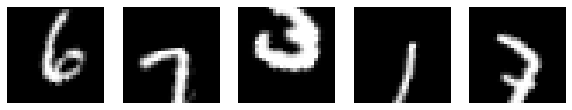

In [6]:
#Visualising Augmented Data
plt.figure(figsize = (10,10))
for i in range(5):
    plt.subplot(1,5, i + 1)
    plt.axis('Off')
    plt.imshow(visual_data[i][4],cmap = 'gray')

**Building the CNN Model**

In [7]:
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, BatchNormalization

cnn_model = Sequential([
    Input(shape = (28, 28, 1)),
    Conv2D(32,(3,3),padding = 'same',activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),padding = 'same',activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3),padding = 'same',activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(126, activation = 'relu'),
    Dense(126, activation = 'relu'),
    
    Dense(10, activation = 'softmax')
])

cnn_model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(0.001),
                 metrics=['sparse_categorical_accuracy'])


2022-08-13 11:39:46.705601: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss",factor=0.1,patience=8, mode="min", min_lr=0.0001)

]


In [9]:
Epochs=60

cnn_model.fit_generator(augmented_training_data, 
                        epochs=Epochs,
                        steps_per_epoch=29400 // Batch_size, #'29400' is 70% of total training data
                        validation_data=validation_data,
                        validation_steps=12600 // Batch_size, #'12600' is 30% of total training data
                        callbacks=callbacks
               )


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-08-13 11:39:47.048129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60
918/918 [==============================] - 34s 36ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.8779 - val_loss: 0.2825 - val_sparse_categorical_accuracy: 0.9131
Epoch 2/60
918/918 [==============================] - 34s 37ms/step - loss: 0.1521 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1413 - val_sparse_categorical_accuracy: 0.9557
Epoch 3/60
918/918 [==============================] - 34s 37ms/step - loss: 0.1176 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.2242 - val_sparse_categorical_accuracy: 0.9350
Epoch 4/60
918/918 [==============================] - 34s 37ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.1355 - val_sparse_categorical_accuracy: 0.9587
Epoch 5/60
918/918 [==============================] - 34s 37ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.1121 - val_sparse_categorical_accuracy: 0.9683
Epoch 6/60
918/918 [==============================] - 34s 37ms/step - loss: 0.0871 - spars

**Prediction and Submission**

In [10]:
prediction = cnn_model.predict(test_x)
prediction = prediction.tolist()
labels=[]

#Generating CSV file for submission

for i in range(28000):
    max_value = np.max(prediction[i])
    labels.append(prediction[i].index(max_value))
    
submission = pd.DataFrame({"ImageId": list(range(1,len(test_x)+1)),
                         "Label": labels})

submission.to_csv("predictions_9.csv", index=False)

    
